In [17]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from functools import partial
import math
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [18]:
train_data = pd.read_csv("/content/Train.csv")
test_data = pd.read_csv("/content/Test.csv")

train_data['event_id'] = train_data['event_id'].apply(lambda x: '_'.join(x.split('_')[0:2]))
train_data['event_idx'] = train_data.groupby('event_id', sort=False).ngroup()
test_data['event_id'] = test_data['event_id'].apply(lambda x: '_'.join(x.split('_')[0:2]))
test_data['event_idx'] = test_data.groupby('event_id', sort=False).ngroup()

train_data['event_t'] = train_data.groupby('event_id').cumcount()
test_data['event_t'] = test_data.groupby('event_id').cumcount()

print(train_data.head())
print(test_data.head())

          event_id  precipitation  label  event_idx  event_t
0  id_spictby0jfsb       0.000000      0          0        0
1  id_spictby0jfsb       0.095438      0          0        1
2  id_spictby0jfsb       1.949560      0          0        2
3  id_spictby0jfsb       3.232160      0          0        3
4  id_spictby0jfsb       0.000000      0          0        4
          event_id  precipitation  event_idx  event_t
0  id_j7b6sokflo4k        0.00000          0        0
1  id_j7b6sokflo4k        3.01864          0        1
2  id_j7b6sokflo4k        0.00000          0        2
3  id_j7b6sokflo4k       16.61520          0        3
4  id_j7b6sokflo4k        2.56706          0        4


In [19]:
len(train_data[train_data.event_id == 'id_p8f40663jj3g'])

730

In [20]:
images_path = ('/content/composite_images.npz')
images = np.load(images_path)
print(images)
print('The folder contains', len(images), 'images, both for train and test.')
print('There are', len(train_data['event_id'].unique()), 'train event ids and', len(test_data['event_id'].unique()), 'test event ids.')

NpzFile '/content/composite_images.npz' with keys: id_rhg5w8vmv3ny, id_rua8ey2jczl0, id_073l04ir88sn, id_wmkfqw7iwjmu, id_heri806er7xw...
The folder contains 898 images, both for train and test.
There are 674 train event ids and 224 test event ids.


In [21]:
# Image metadata constants

# 5 bands and the slope of each image
BAND_NAMES =  ('B2', 'B3', 'B4', 'B8', 'B11', 'slope')
# Image shape
H, W, NUM_CHANNELS = IMG_DIM = (128, 128, len(BAND_NAMES))

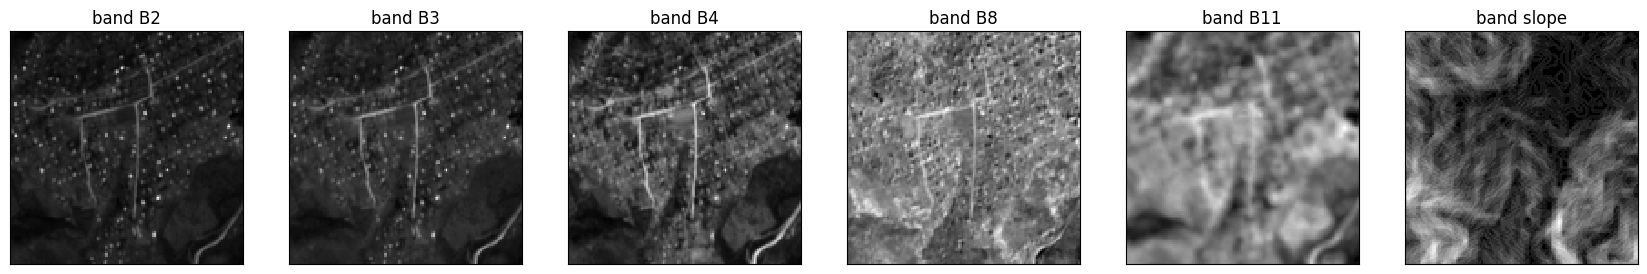

In [22]:

from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.patches as patches
event_id = 'id_rhg5w8vmv3ny'

num_cols = len(BAND_NAMES)
_, axes = plt.subplots(
    ncols=num_cols,
    figsize=(num_cols * 3.5, 3.5),
    facecolor='white',
)

for band_idx in range(num_cols):
  img = images[event_id][..., band_idx]
  axes[band_idx].imshow(img, cmap='gray', interpolation='nearest')
  axes[band_idx].set_title(f'band {BAND_NAMES[band_idx]}')
  axes[band_idx].get_xaxis().set_visible(False)
  axes[band_idx].get_yaxis().set_visible(False)

In [23]:
sample_image = next(iter(images.values()))
assert sample_image.shape == IMG_DIM
assert sample_image.dtype == np.uint16
_MAX_INT = np.iinfo(np.uint16).max

def decode_slope(x: np.ndarray) -> np.ndarray:
  # Convert 16-bit discretized slope to float32 radians
  return (x / _MAX_INT * (math.pi / 2.0)).astype(np.float32)

def normalize(x: np.ndarray, mean: int, std: int) -> np.ndarray:
  return (x - mean) / std

rough_S2_normalize = partial(normalize, mean=1250, std=500)

def preprocess_image(x: np.ndarray) -> np.ndarray:
  return np.concatenate([
      rough_S2_normalize(x[..., :-1].astype(np.float32)),
      decode_slope(x[..., -1:]),
  ], axis=-1, dtype=np.float32)

In [24]:
rng = np.random.default_rng(seed=0xf100d)

event_ids = train_data['event_id'].unique()
new_split = pd.Series(
    data=np.random.choice(['train', 'valid'], size=len(event_ids), p=[0.9, 0.1]),
    index=event_ids,
    name='split',
)
data_new = train_data.join(new_split, on='event_id')

train_df = data_new[(data_new['split'] == 'train')]
train_timeseries = train_df.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()
train_labels = train_df.pivot(index='event_id', columns='event_t', values='label').to_numpy()

valid_df = data_new[data_new['split'] == 'valid']
valid_timeseries = valid_df.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()
valid_labels = valid_df.pivot(index='event_id', columns='event_t', values='label').to_numpy()

# For the test set there are no labels
test_timeseries = test_data.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()

event_splits = data_new.groupby('event_id')['split'].first()

In [26]:
train_images = []
valid_images = []
test_images = []

for event_id in tqdm(event_splits.index):
  img = preprocess_image(images[event_id])
  if event_splits[event_id] == 'train':
    train_images.append(img)
  else:
    valid_images.append(img)

for event_id in tqdm(test_data['event_id'].unique()):
  img = preprocess_image(images[event_id])
  test_images.append(img)

train_images = np.stack(train_images, axis=0)
valid_images = np.stack(valid_images, axis=0)
test_images = np.stack(test_images, axis=0)

  0%|          | 0/674 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

In [27]:
print(f'{train_timeseries.shape=}')
print(f'    {train_images.shape=}')
print(f'    {train_labels.shape=}')

train_timeseries.shape=(596, 730)
    train_images.shape=(596, 128, 128, 6)
    train_labels.shape=(596, 730)


In [28]:
print(f'{valid_timeseries.shape=}')
print(f'    {valid_images.shape=}')
print(f'    {valid_labels.shape=}')

valid_timeseries.shape=(78, 730)
    valid_images.shape=(78, 128, 128, 6)
    valid_labels.shape=(78, 730)


In [29]:
print(f'{test_timeseries.shape=}')
print(f'    {test_images.shape=}')


test_timeseries.shape=(224, 730)
    test_images.shape=(224, 128, 128, 6)


In [30]:
NUM_CLASSES = 2  # Flood / No flood.

def get_datasets():
  """Load train and test datasets into memory."""
  train_ds = {
      'timeseries': train_timeseries,
      'image': train_images,
      'label': train_labels,
  }
  valid_ds = {
      'timeseries': valid_timeseries,
      'image': valid_images,
      'label': valid_labels,
  }

  test_ds = {
      'timeseries': test_timeseries,
      'image': test_images,
  }
  return train_ds, valid_ds, test_ds